# Dataset analysis

In the following notebook we will analyse the data to check how balanced are the summaries and the claims.

In [1]:
import pandas as pd
import numpy as np

DATASET_PATH = "../data/summaries_claims.zip"

In [2]:
df = pd.read_csv(DATASET_PATH) 
df = df.dropna()

Let's check how summaries lengths are distributed.

In [3]:
summaries_length = df["summary"].astype(str).apply(lambda summary: len(summary.split()))
claims_length = df["claim"].astype(str).apply(lambda c: len(c.split()))

summaries_length.describe()

count    26035.000000
mean       980.091185
std       1355.620430
min          7.000000
25%        251.000000
50%        596.000000
75%       1204.000000
max      37829.000000
Name: summary, dtype: float64

Mean length is $\approx 980$ tokens but maximum and minimum are wildly far apart ($37829$ and $7$ respectively).

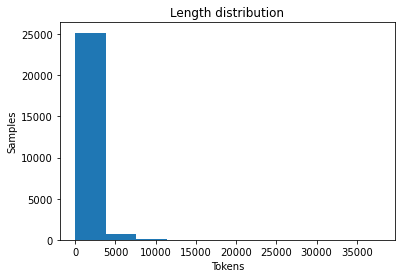

In [4]:
import matplotlib.pyplot as plt
plt.hist(summaries_length)
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()

Indeed summaries longer than $10000$ tokens are exceptionally rare. In fact even summaries with more than $4000$ tokens are uncommon.

In [5]:
sum(summaries_length < 4000) / summaries_length.shape[0]

0.9710389859804109

Summaries whose length is over $4000$ only accounts for $\lt 3\%$ of all the samples.
Let's throw all of those samples with more than $4000$ tokens and see what remaining ones looks like.

count    25281.000000
mean       815.789051
std        785.447507
min          7.000000
25%        243.000000
50%        569.000000
75%       1127.000000
max       3998.000000
Name: summary, dtype: float64


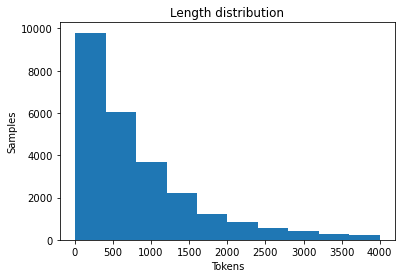

In [6]:
outliers = summaries_length > 4000

print(summaries_length[~outliers].describe())
plt.hist(summaries_length[~outliers])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

Now the distribution looks more like a zipf distribution. This is not a problem per-se but might be a problem when we end up training a neural network on that kind of data.

Let's try to see how summaries with less than $500$ tokens are distributed.

count    11490.000000
mean       227.664317
std        143.443748
min          7.000000
25%        100.000000
50%        218.000000
75%        349.000000
max        499.000000
Name: summary, dtype: float64


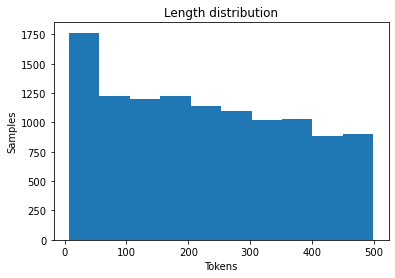

In [7]:
short = summaries_length < 500

print(summaries_length[short].describe())
plt.hist(summaries_length[short])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

The concentration of summaries with length $\leq 50$ is quite high

count    1532.000000
mean       27.582898
std        11.573367
min         7.000000
25%        18.000000
50%        27.000000
75%        37.000000
max        49.000000
Name: summary, dtype: float64


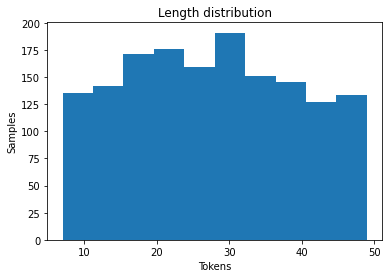

In [8]:
short = summaries_length < 50

print(summaries_length[short].describe())
plt.hist(summaries_length[short])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

Arguably, it's pretty difficult to generate a meaningful claim if the description of the patent itself is shorter than the actual claim we wish to generate.

In [9]:
sum(summaries_length < claims_length) / summaries_length.shape[0]

0.17242173996543114

$\approx 17\%$ of all the documents have a longer claim compared to the description.

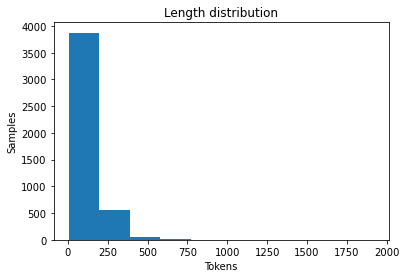

In [10]:
plt.hist(summaries_length[summaries_length < claims_length])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

As we could expect these are mostly documents whose description length is $< 500$.
For this reasons we will remove all the documents whose length is $\leq 500$ along with all those documents whose claim is longer than the summary.

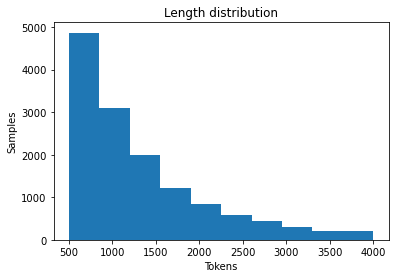

In [11]:
outliers = outliers | (summaries_length < 500) | (claims_length > summaries_length)

plt.hist(summaries_length[~outliers])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

Unfortunately, we will be working with limited resources, hence 

The distribution still looks skewed towards shorter documents.
To address this problem we will partition the documents by summary length in bins of size $200$ and sample $80$ documents in each bin.

In [23]:
MIN_LENGTH = 500
MAX_LENGTH = 4000
BIN_SIZE = 200
SAMPLES_PER_BIN = 80

balanced_df = pd.DataFrame()

for b in range(MIN_LENGTH, MAX_LENGTH, BIN_SIZE):
  in_bin = (summaries_length > b) & (summaries_length < b + BIN_SIZE)
  balanced_df = pd.concat([balanced_df, 
                           df[in_bin].sample(n=SAMPLES_PER_BIN)])

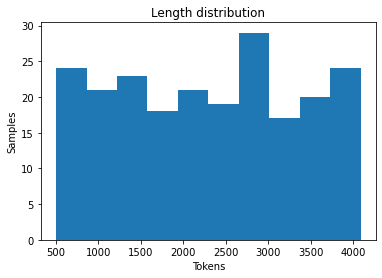

In [25]:
plt.hist(balanced_df["summary"].astype(str).apply(lambda x: len(x.split())))
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

We end up with a smaller dataset, $1440$ documents, which is however balanced in the length of the summary. This is an important aspect as longer documents will articulate the first indipindent claim in a rather different way with respect to shorter documents.

In [26]:
balanced_df.to_csv("balanced_summaries_claims.zip", compression={"method": "zip", "archive_name": "balanced_summaries_claims.csv"})